In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Object Detection with SSD

In [3]:
import h5py
import numpy as np
import simplejson as json
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.utils.data as data

from ssd.generator import CalorimeterJetDataset
from ssd.layers.modules import MultiBoxLoss
from ssd.net import build_ssd
from torch.autograd import Variable

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [6]:
# Set presentation settings
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tick

from matplotlib import cm
from matplotlib.colors import SymLogNorm
from mpl_toolkits import mplot3d

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 6.0)

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Anonymous Pro for Powerline']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 16
matplotlib.rcParams["axes.titlesize"] = 14

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

with open('data2/palette.json') as json_file:
    color_palette = json.load(json_file)
    
colors = [color_palette['lightBlue']['shade_300'],
          color_palette['lime']['shade_300'],
          color_palette['purple']['shade_300'],
          color_palette['teal']['shade_300'],
          color_palette['grey']['shade_300']]

## Build SSD300 in Test Phase

In [7]:
net = build_ssd('test', 300, 2, False)
net.load_weights('models/ssd-jet-binary.pth')

Loading weights into state dict...
Finished!


## Load Image

In [28]:
def plot_calo_image(pixels, batch_labels, y_pred_decoded):

    def x_axis_formatter(x, y):
        x = x - 46
        if x < 0:
            x = x + 360
        if x > 360:
            x = x - 360
        return int(x)
    
    fig = plt.figure(figsize=(16, 6))
    cmap = matplotlib.cm.viridis
    offset = 15
    
    for index, calorimeter in enumerate(pixels):
        
        width = calorimeter.shape[1]
        height = calorimeter.shape[0]
        
        ax1 = plt.subplot(1, 2, index+1)        
        ax1 = plt.gca()
        ax1.set_xlim([-offset, width+offset])
        ax1.set_xlabel('$\eta$', horizontalalignment='right', x=1.0)
        ax1.yaxis.set_major_formatter(tick.FuncFormatter(x_axis_formatter))
        ax1.set_ylim([-offset, height+offset])
        ax1.set_ylabel('$\phi [\degree$]', horizontalalignment='right', y=1.0)

        # Show energy deposits
        im = ax1.imshow(calorimeter,
                        norm=SymLogNorm(linthresh=0.03,
                                        vmin=0,
                                        vmax=pixels.max()),
                        interpolation="nearest",
                        cmap=cmap)

        # Add scale
        cbar = fig.colorbar(im, extend='max')
        cbar.set_label('$E_T$ [GeV]', rotation=90, horizontalalignment='right', y=1.0)
    
        # Add ground truth
        if len(batch_labels):
            for box in batch_labels:
                xmin = box[0]*width
                ymin = box[1]*height
                xmax = box[2]*width
                ymax = box[3]*height

                jet = patches.Rectangle((xmin, ymin),
                                        xmax-xmin,
                                        ymax-ymin,
                                        linewidth=2,
                                        alpha=0.7,
                                        edgecolor=color_palette['red']['shade_600'],
                                        facecolor='none')
                ax1.add_patch(jet)
                ax1.text(xmin,
                         ymin,
                         '{}'.format(CLASSES[int(box[4])]),
                         weight='bold',
                         color=color_palette['grey']['shade_100'],
                         bbox={'facecolor': color_palette['red']['shade_900'], 'alpha': 1.0})

        # Draw the predicted boxes
        for box in y_pred_decoded:
            
            ijet = int(box[0])-1
            xmin = box[1]
            ymin = box[2]
            xmax = box[3]
            ymax = box[4]

            if xmin < 0:
                xmin = 0
            if xmin > 340:
                xmin = 340
                
            if xmax > 340:
                xmax = 340
            if xmax < 0:
                xmax = 0
                
            if ymin < 0:
                ymin = 0

            if ymax > 460:
                ymax = 460
                
            color = colors[ijet]
            
            jet = plt.Rectangle((xmin, ymin),
                                xmax-xmin,
                                ymax-ymin,
                                edgecolor=color,
                                alpha=0.7,
                                facecolor='none',
                                linewidth=2)

            ax1.add_patch(jet)
            
            ax1.text(xmin,
                     ymin,
                     CLASSES[ijet],
                     weight='bold',
                     color='#FAFAFA',
                     bbox={'facecolor': color, 'alpha': 1.0})

        # Add CMS tag
        ax1.text(0,
                 1.04,
                 "CMS",
                 weight='bold',
                 verticalalignment="top",
                 horizontalalignment="left",
                 transform=ax1.transAxes,
                 color="black",
                 fontsize=16)

        # Add title
        if index:
            ax1.set_title('HCAL $E_T$', loc="right")
        else:
            ax1.set_title('ECAL $E_T$', loc="right")
            
    # Show plot
    plt.show();

In [29]:
CLASSES = ['b', 'h', 'W', 't', 'q']
DATA_SOURCE = '/eos/user/a/adpol/ceva/fast'
train_dataset_path = '%s/RSGraviton_NARROW_0.h5' % DATA_SOURCE
num_workers = 1
h5_train = h5py.File(train_dataset_path, 'r')
train_dataset = CalorimeterJetDataset(hdf5_dataset=h5_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=1,
                                           #collate_fn=detection_collate,
                                           shuffle=True,
                                           num_workers=num_workers)

batch_iterator = iter(train_loader)
images, targets = next(batch_iterator)

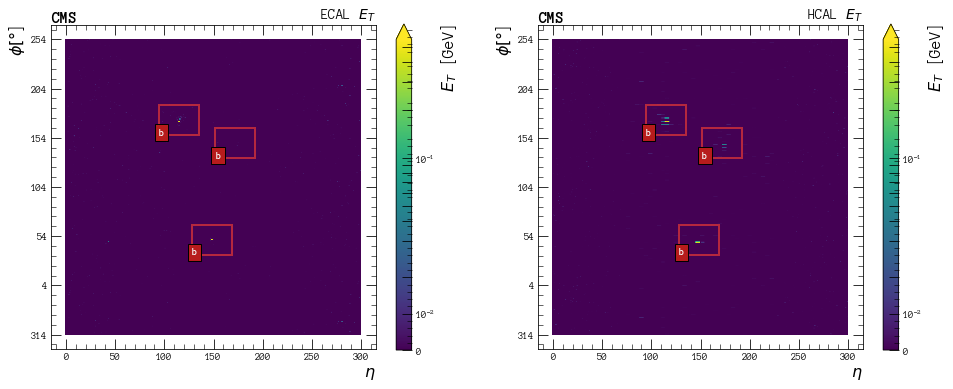

In [30]:
plot_calo_image(images.cpu().numpy()[0], targets.cpu().numpy()[0], [])

In [31]:
if torch.cuda.is_available():
    x = images.clone().detach()
    x = x.cuda()
y = net(x)

detections = y.data
labels = []
coords = []

for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.15:
        score = detections[0,i,j,0]
        pt = (detections[0,i,j,1:]*300).cpu().numpy()
        coords.append(np.append(i, pt))
        j+=1

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 31.72 GiB total capacity; 46.22 MiB already allocated; 4.56 MiB free; 52.00 MiB reserved in total by PyTorch)

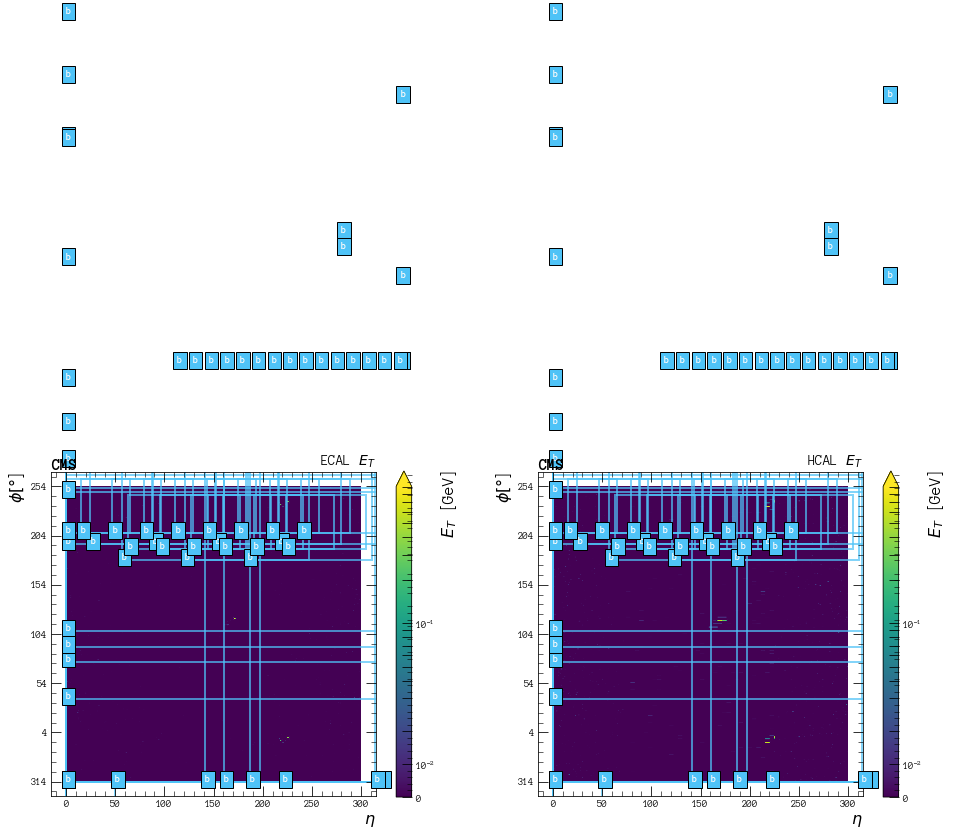

In [46]:
plot_calo_image(images.cpu().numpy()[0], [], coords)